# 12.4 Coding Problems

Name: Nathan Schill

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sympy as sy

## 12.19

In [2]:
# Symbols, expression for f
x, y = sy.symbols('x y')
expr = 100*(y-x**2)**2 + (1-x)**2

# f, f', f''
f = sy.lambdify((x,y), expr)
fp = sy.Matrix([f(x,y).diff(x), f(x,y).diff(y)])
fpp = fp.jacobian(([x,y]))

# Verify
display(f(x,y)), display(fp), display(fpp)

(1 - x)**2 + 100*(-x**2 + y)**2

Matrix([
[-400*x*(-x**2 + y) + 2*x - 2],
[           -200*x**2 + 200*y]])

Matrix([
[1200*x**2 - 400*y + 2, -400*x],
[               -400*x,    200]])

(None, None, None)

In [3]:
# Verify fpp is positive definite at x0
x0 = (-1,1)
pt = {x:x0[0], y:x0[1]}

# Get eigenvalues of f'' at x0
[sy.N(eval) for eval in tuple(fpp.subs(pt).eigenvals().keys())]

[0.399360767487633, 1001.60063923251]

In [4]:
# x1, f(x1), f(x0)
x1 = sy.Matrix(x0) - fpp.subs(pt).inv() * fp.subs(pt)
display(x1), f(*x1), f(*x0)

Matrix([
[ 1],
[-3]])

(None, 1600, 4)

## 12.20

Write an implementation of Newton's method for finding a local minimizer of a function $f : \R^n \to \R$. Your code should accept a twice-differentiable function $f$, an initial guess $x_0$, a desired level of accuracy $\varepsilon$, and a maximum number of iterations $M$. At each step it should calculate $x_{k_1} = x_k - D^2f(x_k)^{-1}Df(x_k)^\mathbf{\top} $ and then repeat step until it reaches a good approximation to a critical point of $f$ or exceeds $M$ iterations. For the stopping criterion, use $\| x_{k+1}  -  x_k \|  < \varepsilon$. Be sure your code has methods for identifying and handling cases where the algorithm fails or the sequence does not converge. 

In [5]:
def newton(f, df, d2f, x0, eps=1e-5, M=1000):
    '''Return: 
    - minimizer (array)
    - guesses (array)
    - number of steps/iterations (int)
    - whether it converged (bool)
    '''
    
    xs = [x0] + [None]*M
    converged = False
    
    for i in range(M):
        # Get D2f(xk)^-1 Df(xk)^T by solving D2f(xk) yk = Df(xk)^T
        y0 = np.linalg.solve(d2f(x0), df(x0))

        # Get next iteration
        x0 = x0 - y0

        # Store
        xs[i+1] = x0

        # Check if converged
        if np.linalg.norm(xs[i+1] - xs[i]) < eps:
            converged = True
            break

    return x0, np.array([xk for xk in xs if xk is not None]), i+1, converged

## 12.21

Apply your Newton code from **Exercise 12.20** to the Rosenbrock function with an initial guess of $x_0 = (x_0 ,y_0 ) = (-2,2)$. Does it converge? If not, explain why not. If it does, how many iterations does it take to get within $10^{-5}$ of the true minimizer? 

In [6]:
# Rosenbrock
f = lambda x : (1-x[0])**2 + 100*(x[1]-x[0]**2)**2
df = lambda x : np.array([-2*(1-x[0]) - 400*x[0]*(x[1]-x[0]**2), 200*(x[1]-x[0]**2)])
d2f = lambda x : np.array([[2-400*x[1] + 1200*x[0]**2, -400*x[0]],[-400*x[0], 200]])

x0 = np.array([-2, 2])

In [7]:
newton(f, df, d2f, x0)

(array([1., 1.]),
 array([[-2.        ,  2.        ],
        [-1.9925187 ,  3.97007481],
        [ 0.96687269, -7.82315462],
        [ 0.96689159,  0.93487935],
        [ 1.        ,  0.99890383],
        [ 1.        ,  1.        ],
        [ 1.        ,  1.        ]]),
 6,
 True)

It converged.

Number of iterations: 6

### Not Required: Use this to plot the convergence!

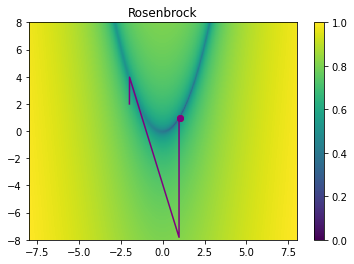

In [8]:
my_min, xs, num_step, conv = newton(f, df, d2f, np.array([-2,2]))

dom = np.linspace(-8,8,1000)
X, Y = np.meshgrid(dom, dom)
Z = f(np.array([X,Y]))

plt.pcolor(X,Y,Z, norm=matplotlib.colors.LogNorm())
plt.scatter(1,1, color='red')

# estimated minimizer at each iteration
plt.plot(xs[:,0],xs[:,1], color='purple')

# final estimate
plt.scatter(my_min[0],my_min[1], color='purple')

plt.title('Rosenbrock')
plt.colorbar()
plt.show()

## 12.23

Code up an implementation of the Gauss-Newton algorithm for solving NLS problems. Your code should accept a differentiable function $r : \R^n \to \R^m$, defining an objective function $f(x) = r(x)^\mathbf{\top} r(x)$, an initial guess $x_0 \in \R^n$, a desired level of accuracy $\varepsilon$, and a maximum number of iterations $M$. At each step it should calculate $J(x_k) = Dr(x_k)^\mathbf{\top}$ and compute $x_{k+1}$ via **(12.23)**, and then repeat until it reaches a good approximation to a critical point of $f$, or exceeds $M$ iterations. For the stopping criterion, use $\| x_{k+1}  -  x_k\| < \varepsilon$. Apply your code to the range finder problem **(Example 12.4.10 and Figure 12.9)** with the data given in the example. 

Verify that when starting at $x_0 = (2,0)$ your code converges in eight steps to the minimizer $(2.9546367, 2.88618843)$. 

In [56]:
# Machine precision for df function below and for precision in problem
E = np.finfo(float).eps

def df(f, x, h=1.4*E**(1/3)):
    '''(My code from section 11.4 HW.)
    Given f: Rn -> Rm, get estimate for Df(x) using centered differences.

    Parameters:
        f (callable function): Rn -> Rm
        x (ndarray, float): point in Rn
        h (float): step size, default 1.4*cuberoot(machine epsilon)
    Return:
        Estimate of Df(x)
    '''

    def ek(n, k):
        '''Return kth standard basis vector in R^n.''' 
        ek = np.zeros(n)
        ek[k] = 1
        return ek

    # Get n, m
    n = 1 if np.isscalar(x) else len(x)
    m = 1 if np.isscalar(f(x)) else len(f(x))

    # Define J
    J = np.zeros((m, n))

    # Get columns of J
    for j in range(n):
        J[:,j] = (f(x + h*ek(n,j)) - f(x - h*ek(n,j)))/(2*h)

    return J

In [35]:
# xtrue = np.array([3,3]) for reference

# Coordinates of range finders
a = [[0,0], [1,1], [2,0], [-1,3]]
a = np.array(a)

# Measured distances
d = np.array([3.88506517, 2.87540403, 3.10537735, 3.99674185])

# Initial guess for xtrue
x0 = np.array([2, 0])

def r_def(d, a):
    '''Function r composed of r_i, used for objective function f = r(x)^T r(x)'''
    return lambda x: d - np.linalg.norm(x-a, axis=1)

r = r_def(d, a)

In [57]:
def gn(r, x0, eps=1e-5, M=1000):
    '''Gauss-Newton algorithm'''

    # Objective function r(x)^T r (not used in actual computation)
    # f = lambda x: r(x)@r(x)

    # Successive approximations
    xs = [x0] + [None]*M
    converged = False
    
    for i in range(M):
        # Derivative of r at x0
        rx = r(x0)
        Drx = df(r, x0)

        # Get (DrxT Drx)^-1 DrxT rx by solving (DrxT Drx) y0 = DrxT rx
        y0 = np.linalg.solve(Drx.T @ Drx, Drx.T @ rx)

        # Get next iteration
        x0 = x0 - y0

        # Store
        xs[i+1] = x0

        # Check if converged
        if np.linalg.norm(xs[i+1] - xs[i]) < eps:
            converged = True
            break

    return x0, np.array([xk for xk in xs if xk is not None]), i+1, converged

In [59]:
minimizer, steps, num_steps, converged = gn(r, x0, np.sqrt(E))

print('Num steps:', num_steps)

print('Minimizer:', minimizer)

Num steps: 8
Minimizer: [2.9546367  2.88618843]
